<center> <h1>Data Analysis with Numpy and Matplotlib</h1> </center>
<center> <h2>(for geoscientists)</h2> </center>

The best way to learn how to program is to do something useful, so this introduction to Python is built around a common scientific task: data analysis.

This lesson borrows in part from a Software Carpentry lesson found  <a href="https://swcarpentry.github.io/python-novice-inflammation/">here</a>. Software Carpentry is a volunteer non-profit organization dedicated to teaching basic computing skills to researchers.  They have many excellent instructors who work with laboratories all over the world.

## Why Python? ##

 - it’s free, well-documented, and runs almost everywhere;
 - it has a large (and growing) user base among scientists; and
 - experience shows that it’s easier for novices to pick up than most other languages.


In this example, we are looking at ShakeMap PGA&ast; data from Oklahoma that has been "stacked" and resampled to a common grid.  The "stack" represents a number of ShakeMap PGA grids that have been resampled to a common grid and stacked on top of each other, so that the result is a *cube* of numbers, with the same number of rows and columns for each layer.  Each layer represents one resampled ShakeMap.  Cells with no data are represented by a NaN, or Not-A-Number. 

&ast; For the unaware, PGA stands for "Peak Ground Acceleration", and its units are "percent-g".  So, a value of 100 represents 1 g, or 9.8 meters per seconds squared.

For the purposes of this exercise, the data we need has been pre-packaged and stored in the Numpy binary compressed format. The original data was created by the *shakestack* tool, details about which can be found here:

https://github.com/mhearne-usgs/comcatapps

First, we'll need to *import*&ast; the packages we need to load the data and do some quick visualizations.  These packages are:

 - NumPy:  The fundamental package for scientific computing with Python. It contains among other things:
   - a powerful N-dimensional array object
   - sophisticated (broadcasting) functions
   - tools for integrating C/C++ and Fortran code
   - useful linear algebra, Fourier transform, and random number capabilities
 - Matplotlib: a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
 
&ast; Notes on importing:  There are a couple of different ways to import packages into Python, but here we'll use conventions that are common in the scientific Python community, which hopefully makes reading one another's code easier. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

We're also going to include here a "magic" Jupyter command... there are a number of these, which we won't explain now, but suffice it to say that this one allows any matplotlib plots to appear "inline" (i.e., not pop up) in the Jupyter notebook.

In [3]:
%matplotlib inline

Loading data in the numpy format is pretty easy - we just call the "load" method defined by the numpy package.  What we get back will be a 3D data array.

In [4]:
pga_cube = np.load('pgacube.npz')['arr_0']

We can learn a few things about this array interactively.  Let's try looking at its dimensions and type (i.e., is it a 32 bit floating point array, 16 bit integer array...): 

In [6]:
print(pga_cube.shape) #the dimensions of the array
print(pga_cube.dtype) #the data type of the array

(264, 455, 50)
float64


We see above the array has 264 rows and 455 columns.  Lacking a commonly held standard for what to call the third dimension, let's call them "layers".  So here, our array has 50 layers. 

Because this array is three dimensional, it's a bit difficult to visualize it as is.  However, we can look at individual layers.  To do this, we'll use numpy's *slicing* syntax, which is similar to Matlab's, except that:
 - indices start at 0 instead of 1, and
 - square brackets are used instead of parentheses
 
 Let's extract the first layer.  Indexing, like in Matlab, goes rows, then columns, then layers, etc.  

Here we're saying extract all rows, all columns, and the 0th layer.

In [7]:
first_layer = pga_cube[:,:,0] 
first_layer

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

Now we can use matplotlib's *imshow* function to display this first layer, and the *colorbar* function to show us the range of values.

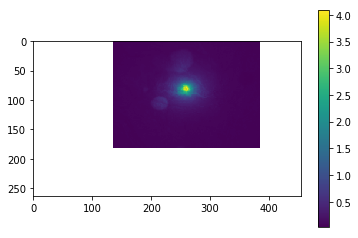

In [8]:
plt.imshow(first_layer);
plt.colorbar();

There are a number of things here we might find unsatisfactory.  First, the plot is a little small. Second, the default colormap is *viridis*, something we can change.  Third, we don't get a lot of contrast using default scaling.  Finally, the colorbar height doesn't match the figure - which solution is involved enough I'm stealing it from StackOverflow: 

https://stackoverflow.com/a/18195921/7723531

We'll define a function to solve all of these problems, and use it several more times as we continue through the notebook.

In [9]:
def plot_image(img,title_str):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    #scaling the data
    dmean = np.nanmean(img)
    dstd = np.nanstd(img)
    dmax = dmean + dstd*3

    #change the colormap
    colormap = cm.jet #everybody's favorite

    #make a bigger figure, nominally 12 inches wide by 8 tall,
    #but the figure is scaled to the size of our browser window.
    plt.figure(figsize=(12,8));

    #plot data with new scaling and colormap
    im = plt.imshow(img,vmin=0,vmax=dmax,cmap=colormap);

    #to be complete, let's add a title
    plt.title(title_str);
    
    #scale the colorbar
    #https://stackoverflow.com/a/18195921/7723531
    #import this magic function
    
    ax = plt.gca(); #get the current axes object
    #do some magic stuff to make a new axes
    divider = make_axes_locatable(ax);
    cax = divider.append_axes("right", size="5%", pad=0.05);
    #draw colorbar in new divider axes
    plt.colorbar(im, cax=cax);  

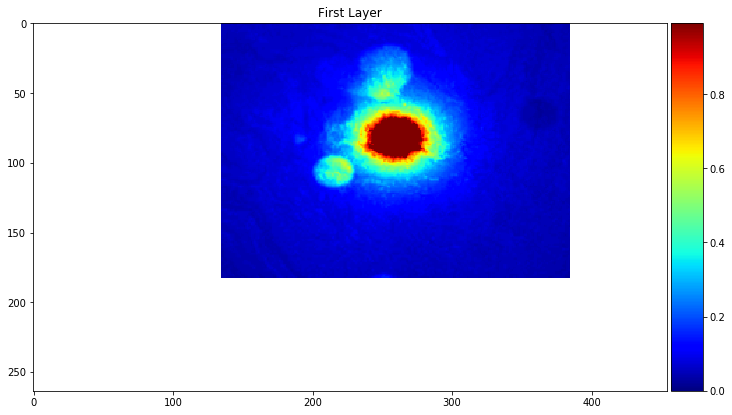

In [10]:
plot_image(first_layer,'First Layer')

Note that there is a lot of whitespace between the edges of the image and the edges of the figure.  These cells contain NaN values, since this ShakeMap does not cover the entire area of the stacked grid.

*Note:* Matplotlib has a *lot* of colormaps to choose from, see this page for a guide:

https://matplotlib.org/users/colormaps.html

Now that we can cleanly visualize our layers, let's use this as an opportunity to learn about indexing into arrays.

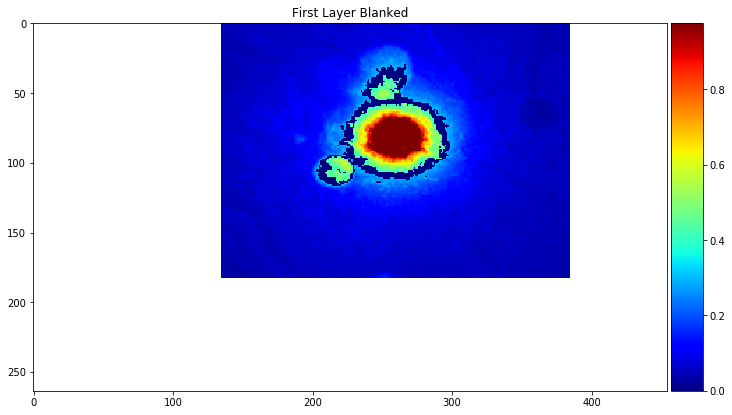

In [13]:
first_layer_blanked = first_layer.copy() #make a copy of the data
indices = (first_layer > 0.3) & (first_layer < 0.4)
first_layer_blanked[indices] = 0;
plot_image(first_layer_blanked,'First Layer Blanked')

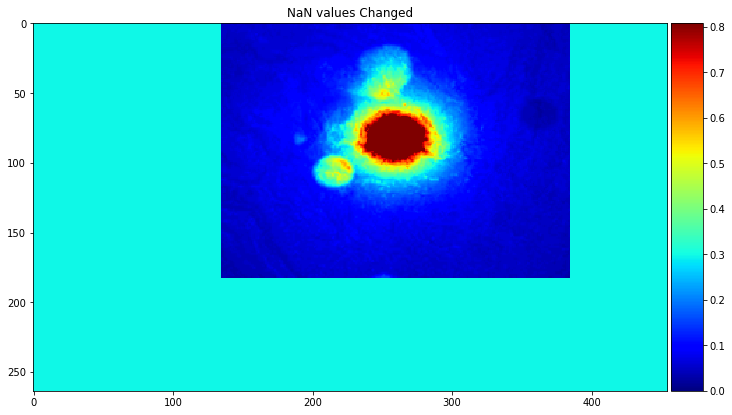

In [18]:
first_layer_nans_changed = first_layer.copy()
indices = np.isnan(first_layer_nans_changed)
first_layer_nans_changed[indices] = 0.3
plot_image(first_layer_nans_changed,'NaN values Changed')

Now Let's look at the last layer of the array.  To get the last index in any array in a given dimension, you can use -1.  To get the second-to-last index, use -2, and so on.

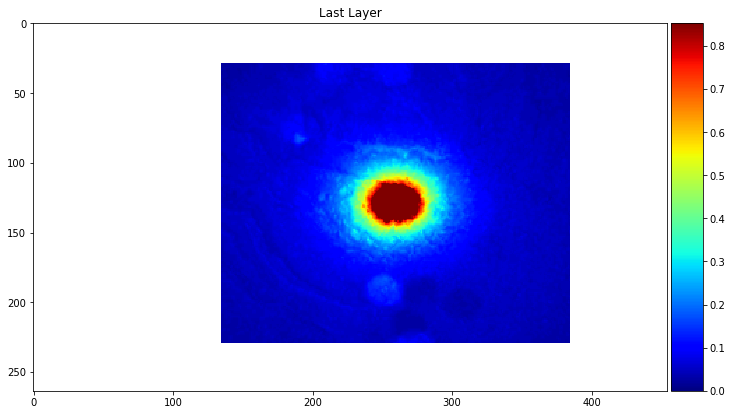

In [19]:
last_layer = pga_cube[:,:,-1] 
plot_image(last_layer,'Last Layer')

You can see that the peak of ground motion is shifted south relative to the first layer, and the layer has a different extent.

We can also do some arithmetic and statistical operations on these layers, individually or together.  Since these arrays have NaN values, we'll be using numpy's nan- equivalents of the normal functions.

In [20]:
#get the sum of all values in each of the two layers, ignoring NaNs
print('Sums:')
print(np.nansum(first_layer))
print(np.nansum(last_layer))
print()

#get the mean of all values in each of the two layers, ignoring NaNs
print('Means:')
print(np.nanmean(first_layer))
print(np.nanmean(last_layer))
print()

#get the maximum of all values in each of the two layers, ignoring NaNs
print('Maximums:')
print(np.nanmax(first_layer))
print(np.nanmax(last_layer))
print() 

Sums:
6760.87583112
5694.7184122

Means:
0.147778706691
0.113327729596

Maximums:
4.09452430616
4.96459392426



We can also add the two layers together, and then visualize the resulting grid.  To add them together, we'll have to replace the NaN values with zeros, which we can do with a little indexing and the numpy isnan() function.

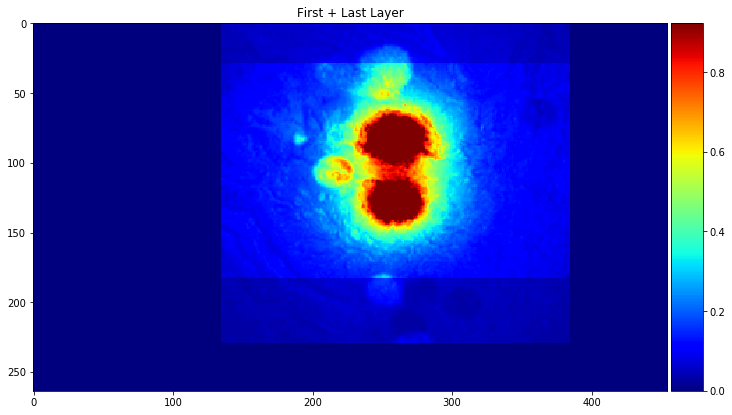

In [22]:
first_layer_copy = first_layer.copy()
last_layer_copy = last_layer.copy()
first_layer_copy[np.isnan(first_layer_copy)] = 0
last_layer_copy[np.isnan(last_layer_copy)] = 0
layer_sum = first_layer_copy + last_layer_copy
plot_image(layer_sum,'First + Last Layer')

So here we can clearly see the two peaks of ground motion in the same image.

You can also do element by element operations of arrays with scalar values - for example, we could double the values in this summed layer:

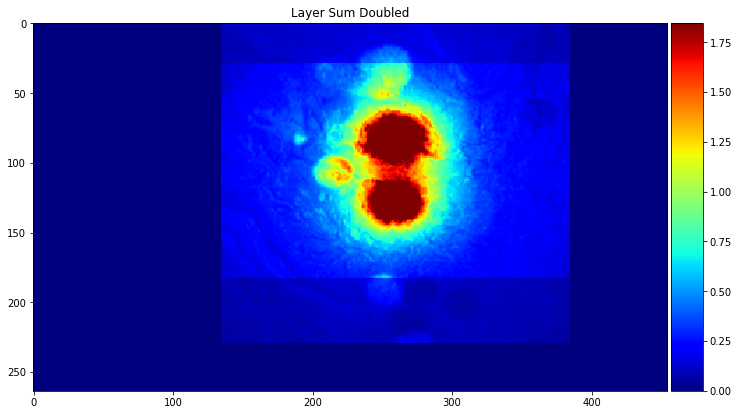

In [23]:
layer_double = layer_sum * 2
plot_image(layer_double,'Layer Sum Doubled')

We can also do statistical operations on the original cube - for example, take the mean of all the rows and columns along the third axis, giving us the average ground motion over the whole study area for all ShakeMaps.  

*Note*: We will be getting a warning from numpy here because we're using the nanmean method in a way that returns NaN in some cells, which is theoretically surprising given the purpose of nanmean.

/Users/mhearne/miniconda3/envs/notebooks/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


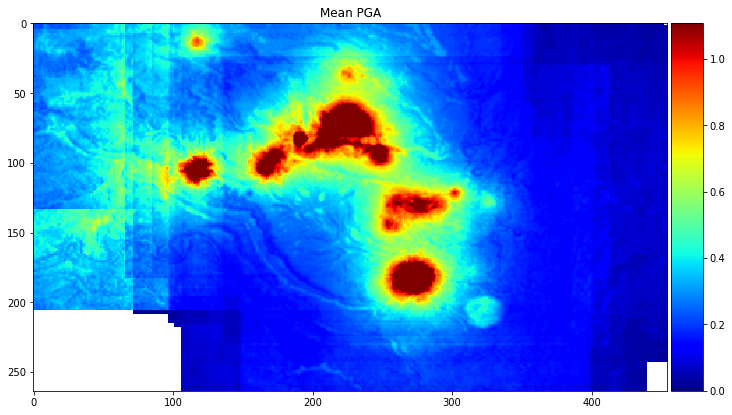

In [24]:
pga_mean = np.nanmean(pga_cube,axis=2); #axes start at 0, so axis 2 is the third one
plot_image(pga_mean,'Mean PGA')

Let's repeat this with the maximum value.

/Users/mhearne/miniconda3/envs/notebooks/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


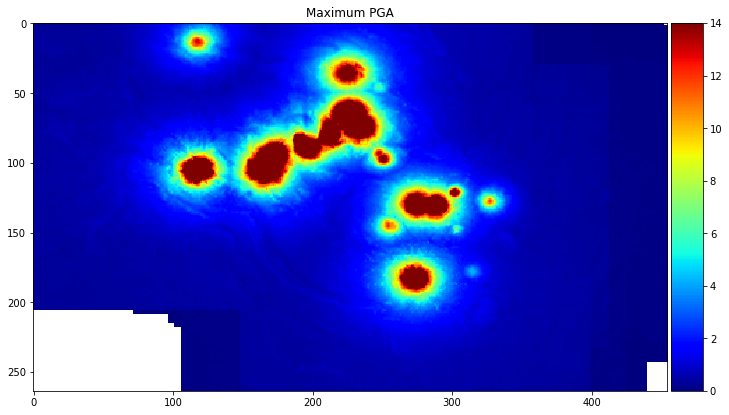

In [25]:
pga_max = np.nanmax(pga_cube,axis=2); #axes start at 0, so axis 2 is the third one
plot_image(pga_max,'Maximum PGA')

We can also use slicing to drill down vertically into the original cube of data, extracting a vertical profile.  Let's do this at the location of the highest value of the maximum grid, then sort the resulting array of values.

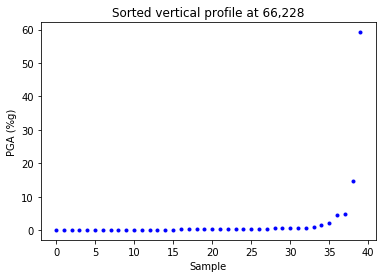

In [26]:
idx = np.nanargmax(pga_max) #this is a flattened index
row,col = np.unravel_index(idx,pga_max.shape) #turn flat index into row/column indices
core_sample = pga_cube[row,col]
plt.plot(np.sort(core_sample),'b.');
plt.xlabel('Sample');
plt.ylabel('PGA (%g)');
plt.title('Sorted vertical profile at %i,%i' % (row,col));

<center> <h2>Resources</h2> </center>

There is a wealth of resources for Python programming and data analysis on the web.  Below are some links to resources for further exploration on the topics we just covered.  

Generally speaking, Google and stackoverflow.com are your friends - much of the time, typing in a well-worded question in Google will lead to an answer on stackoverflow.

 - Jupyter Notebooks: https://jupyter.readthedocs.io/en/latest/content-quickstart.html
 - Numpy Functions: https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.math.html
 - Matplotlib tutorial: https://matplotlib.org/users/pyplot_tutorial.html
 